In [15]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neurotools.io.gdrive import download_sheets_doc
%matplotlib inline

# PROCESS EMBEDDING AND DIMENSIONS

## LOAD EMBEDDING AND DIMENSIONS

In [2]:
emb = gensim.models.KeyedVectors.load_word2vec_format('005_en_in_commoncrawl_v1_20180330.bin', binary=True)

In [3]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [ ]:
dimensions_doc_id = '1qa6hmUwjipTocTLIAIBEuObkzVGwWUvYXV04HjMw0BM'
dimensions_doc = download_sheets_doc(dimensions_doc_id, has_column_labels=True)
dimensions_nf = dimensions_doc['dimensions_v2.csv']
dimensions_nf = dimensions_nf.loc[(dimensions_nf['whisky_relevant'] == '1') & (dimensions_nf['en'] != ''), ['en_label', 'en']]
dimensions_nf['en_label'] = 'nf_' + dimensions_nf['en_label']

In [ ]:
diageo_dimensions_doc_id = '1_OdlI2ieNMAXAepeqtjDIghRVj6Lgoaf9caiZK8jmkA'
diageo_dimensions_doc = download_sheets_doc(diageo_dimensions_doc_id, has_column_labels=True)
dimensions_diageo = diageo_dimensions_doc['Dimensions']
dimensions_diageo = dimensions_diageo.loc[dimensions_diageo['Content'] != '', ['Dimension', 'Content']]
dimensions_diageo['Dimension'] = 'dg_' + dimensions_diageo['Dimension']

In [ ]:
dimensions_nf.columns = ['Dimension', 'Content']

In [ ]:
dimensions_nf.shape

In [ ]:
dimensions = pd.concat([dimensions_diageo, dimensions_nf], axis=0, ignore_index=True)

## GET WORD VECTORS OF DIMENSIONS

In [ ]:
dimensions['tokens'] = dimensions['Content'].str.lower().str.replace(r'[^a-z ]', '').str.split()

In [232]:
dimensions['wv'] = dimensions['tokens'].map(lambda x: get_average_vector(x, emb))

In [233]:
dimensions.head()

,Dimension,Content,tokens,wv
0,dg_Relaxed,relax unwind enjoy soothe calm serene leisurel...,"[relax, unwind, enjoy, soothe, calm, serene, l...","[-0.38982093, 1.0310897, -0.3649658, -1.062084..."
1,dg_Confident,confident optimistic hopeful reassure certainl...,"[confident, optimistic, hopeful, reassure, cer...","[0.35235944, -2.103267, 0.75326306, -2.0183167..."
2,dg_Welcoming,welcome greet warmly hospitable invite graciou...,"[welcome, greet, warmly, hospitable, invite, g...","[0.32264853, -1.3409846, 0.8682901, -1.4583006..."
3,dg_Social,social civil collective community cordial,"[social, civil, collective, community, cordial]","[0.95336664, -1.0829761, 1.1170304, -0.0309140..."
4,dg_Playful,playful delightful lighthearted lively flirtat...,"[playful, delightful, lighthearted, lively, fl...","[-0.72059196, -0.50438666, -0.35774776, -1.436..."


In [234]:
dimensions.shape[0]

46

# LOAD CANDIDATE WORDS

In [236]:
diageo_words_doc_id = '1Vc_NYmC69G0KkdvrUS79jhhu85p5wkhfGnwc9aHTDeM'
diageo_words_doc = download_sheets_doc(diageo_words_doc_id, has_column_labels=True)

In [237]:
ingredients = ['malt', 'grain']
flavors = ['sweet, sweetness',
           'richness, rich',
           'smooth, smoothness',
           'fruity',
           'woody wood taste']
smart_thinking = ['streetwise, streetsmart, thinking, clever, sharp, ease', 'smooth, smoothness']

In [238]:
def get_words_from_df(df):
    return list(df['Word'].values)

In [239]:
def get_words_for_hook(sheet_dict, hook_keys):
    container = []
    for key in hook_keys:
        container.extend(get_words_from_df(sheet_dict[key]))
    return set(container)

In [240]:
words_ingredients = get_words_for_hook(diageo_words_doc, ingredients)
words_flavors = get_words_for_hook(diageo_words_doc, flavors)
words_smart_thinking = get_words_for_hook(diageo_words_doc, smart_thinking)

In [241]:
def get_df_for_hook(words):
    df = pd.DataFrame(list(words), columns = ['word'])
    df['wv'] = df['word'].map(lambda x: get_average_vector([x], emb))
    return df

In [242]:
df_ingredients = get_df_for_hook(words_ingredients)
df_flavors = get_df_for_hook(words_flavors)
df_smart_thinking = get_df_for_hook(words_smart_thinking)

# GET SIMILARITY OF WORDS WITH DIMENSIONS

In [243]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [244]:
def get_similarity_with_dimensions(row, dimensions):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        dimensions : dataframe containing Neuroflash dimensions
    """
    for k in range(dimensions['Dimension'].shape[0]):
        name = 'dim_' + str(dimensions['Dimension'].iloc[k])
        # define a new column for the cosine similarity of dimension k and the post text
        row[name] = cosine_similarity(row['wv'], dimensions['wv'].iloc[k])
    return row

In [245]:
df_ingredients = df_ingredients.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)
df_flavors = df_flavors.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)
df_smart_thinking = df_smart_thinking.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)

In [271]:
df_ingredients.drop(columns=['wv']).to_csv('csv/sim_ingredients.csv', index=False)
df_flavors.drop(columns=['wv']).to_csv('csv/sim_flavors.csv', index=False)
df_smart_thinking.drop(columns=['wv']).to_csv('csv/sim_smart_thinking.csv', index=False)

In [273]:
def sum_over_dimensions(df, nf_only = True):
    if nf_only:
        consider = df[[x for x in df.columns if 'dim_nf' in x]]
        labels = ['word', 'sum_over_NF_dims']
    else:
        consider = df[[x for x in df.columns if 'dim' in x]]
        labels = ['word', 'sum_over_dims']
    sum_df = pd.concat([df.iloc[:,0], consider.sum(axis=1)], axis=1)
    sum_df.columns = labels
    return sum_df.sort_values(labels[1], ascending=False)

In [274]:
sum_over_dimensions(df_ingredients).head(20)

,word,sum_over_NF_dims
5,fruity,3.792745
31,malty,2.847420
7,vegetable,2.004845
10,coarse,1.630495
86,unprocessed,1.604073
59,grain,1.601987
38,starchy,1.573729
9,beer,1.475540
96,vermouth,1.452845
63,tipple,1.447242


In [275]:
sum_over_dimensions(df_flavors).head(20)

,word,sum_over_NF_dims
104,truly,5.599674
43,charm,5.391906
60,wonderfully,5.264797
77,subtle,5.234277
53,vibrant,5.204802
109,comfortable,5.190671
188,unique,5.128155
166,delicate,4.999129
26,earthy,4.872749
20,exquisite,4.834724


In [276]:
sum_over_dimensions(df_smart_thinking).head(20)

,word,sum_over_NF_dims
71,attractive,5.384535
39,subtle,5.234277
53,comfortable,5.190671
0,simplicity,5.079498
49,sophisticate,5.023508
78,delicate,4.999129
81,perfectly,4.754438
64,effortless,4.583854
74,simple,4.563620
79,gentle,4.551089


In [277]:
sum_over_dimensions(df_ingredients).to_csv('csv/top_ingredients.csv', index=False)
sum_over_dimensions(df_flavors).to_csv('csv/top_flavors.csv', index=False)
sum_over_dimensions(df_smart_thinking).to_csv('csv/top_smart_thinking.csv', index=False)

# Plots

In [6]:
top_ingredients = pd.read_csv('csv/top_ingredients.csv')
top_flavors = pd.read_csv('csv/top_flavors.csv')
top_smart_thinking = pd.read_csv('csv/top_smart_thinking.csv')

In [53]:
def plot_bargraph(df, hook):
    plt.figure(figsize=(17,9))
    plt.title('Hook: {}'.format(hook), size=20)
    plt.bar(range(50), df.set_index('word').head(50).sort_values('sum_over_NF_dims').values)
    plt.xticks(range(50),  df.head(50).sort_values('sum_over_NF_dims')['word'], rotation=90, size=15);
    plt.ylabel('Sum of Similarity over Whiskey Dims', size=20)
    plt.savefig('plot/topwords_{}.png'.format(hook), bbox_inches='tight', dpi=300)

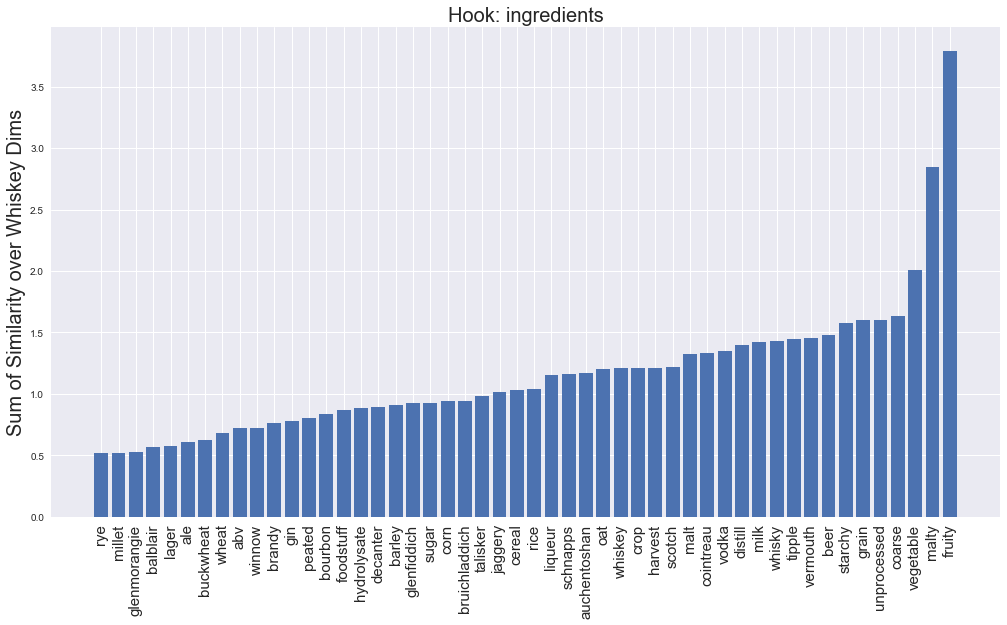

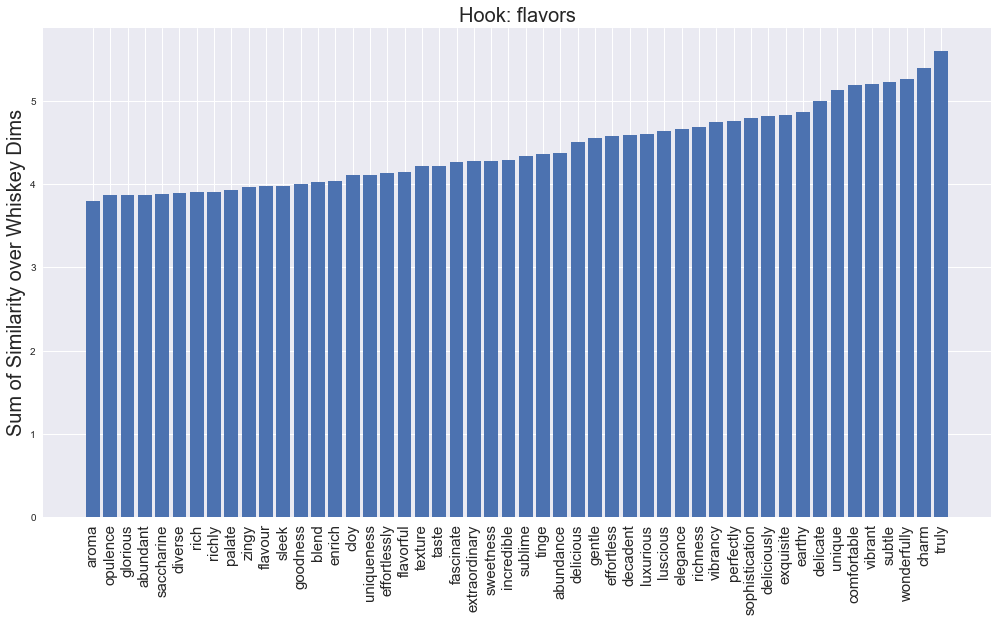

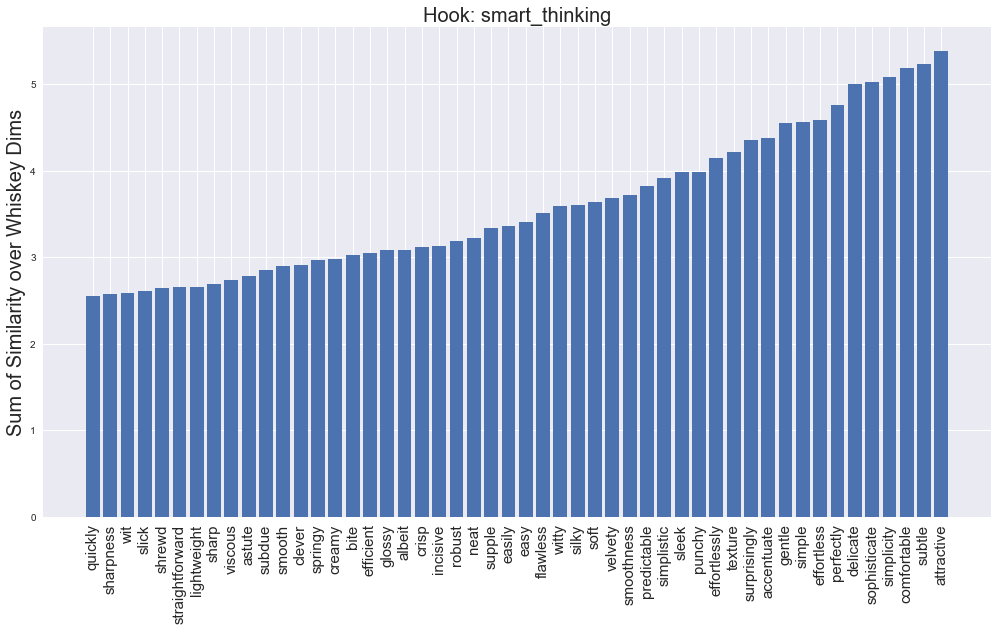

In [54]:
plot_bargraph(top_ingredients, 'ingredients')
plot_bargraph(top_flavors, 'flavors')
plot_bargraph(top_smart_thinking, 'smart_thinking')